# MACD Analysis and Buy/Sell Signals


> MACD, short for moving average convergence/divergence, is a trading indicator used in technical analysis of stock prices. 
Source: https://en.wikipedia.org/wiki/MACD

We analyse stock data using MACD and generate buy and sell signals.

#### Some installs and imports

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install stockstats
!{sys.executable} -m pip install seaborn

In [2]:
# imports
import pandas as pd
import numpy as np
from stockstats import StockDataFrame as Sdf

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

## MACD Parametrization

Below there is an example of MACD calculation:

    The MACD line (macd): 12-day EMA - 26-day EMA
    Signal Line (macds): 9-day EMA of MACD Line

The parameter are (fast, slow, signal) = (12, 26, 9). 
We generalize the example above and compute the parameterize MACD as follows:

\begin{align}
MACD^{fast, slow}(t) & = EMA^{fast}(close, t) - EMA^{slow}(close, t) \\
Signal^{sig}(t) & = EMA^{sig}(MACD^{fast, slow}(t), t) \\
\end{align}

In [3]:
#
# original from stockstats source
# modified to paramterize it
#

def macd_params(df, fast_window=12, slow_window=26, signal_window=9):
    """ Moving Average Convergence Divergence

    This function will initialize all following columns.

    MACD Line (macd): (fast_window EMA - slow_window EMA)
    Signal Line (macds): signal_window EMA of MACD Line
    MACD Histogram (macdh): MACD Line - Signal Line
    
    :param df: data
    :param fast_window: window length of the fast EMA 
    :param slow_window: window length of the slow EMA
    :param signal_window: window length of the signal EMA
    
    :return: None
    """
    
    # parameter check
    if (fast_window > slow_window) or (signal_window > fast_window):
        # error
        raise ValueError('Parameter values do not fit.')
    
    fast = df['close_' + str(fast_window) + '_ema']
    slow = df['close_' + str(slow_window) + '_ema']
    df['macd'] = fast - slow
    df['macds'] = df['macd_' + str(signal_window) + '_ema']
    df['macdh'] = (df['macd'] - df['macds'])

    del df['macd_' + str(signal_window) + '_ema']
    del fast
    del slow
    
    

## Data Import

The data download is from ariva.de. The import adjust some formatting in order to work with python's `stockstats` package. 

* delimiter is ';'
* header line uses english idenifiers
* decimal separator is specified as ','
* thousands separator is '.'

In [4]:
# Data path
data_path = '../data/external/data.csv'

# import data
colnames = ['date', 'open', 'high', 'low', 'close', 'shares', 'volume']
data = pd.read_csv(data_path, delimiter=';', header=0, names=colnames, decimal=',', thousands='.')
stock  = Sdf.retype(data)

# sort by date ascending 
stock.sort_index(ascending=True, inplace=True)


## Compute MACD and Visualize

In [5]:
# compute macd with standard param (12 / 26 / 9)
macd_params(stock)

macd = stock['macd']
macds = stock['macds']

In [6]:
stock.head()

,open,high,low,close,shares,volume,close_12_ema,close_26_ema,macd,macds,macdh
date,,,,,,,,,,,
2017-08-21,174.3375,175.6815,173.1374,174.0495,776936,135380672,174.049500,174.049500,0.000000,0.000000,0.000000
2017-08-22,175.2015,176.1615,174.8655,175.5855,714906,125526592,174.881500,174.847038,0.034462,0.019145,0.015316
2017-08-23,175.5375,176.0655,174.0014,174.3375,800080,139733784,174.669177,174.663966,0.005210,0.013434,-0.008224
2017-08-24,174.4815,176.5935,174.4815,175.4415,725802,127510400,174.912969,174.881331,0.031638,0.019601,0.012037
2017-08-25,175.3455,176.3535,174.8175,174.9135,673465,118082856,174.913113,174.888791,0.024322,0.021005,0.003317


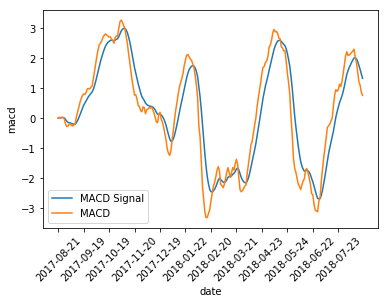

In [7]:
# visualize MACD and MACD signal
stock.reset_index(inplace=True)
sns.lineplot(data=stock, x='date', y='macds', label='MACD Signal')
sns.lineplot(data=stock, x='date', y='macd', label='MACD')
l=stock.date.count()/12
plt.xticks(stock.date[0::int(l)], rotation=45)
plt.show()

## Compute Buy/Sell Signals

The buy/sell signals are the result when the MACD and the MACD-Signal cross each other.

* MACD - Moving Average Convergence/Divergence
* MACD Signal - EMA of MACD

**BUY** Signal: $ MACD(t-1) < Signal(t-1) \textrm{ and } MACD(t) > Signal(t) $ <br>
**SELL** Signal: $ MACD(t-1) > Signal(t-1) \textrm{ and } MACD(t) < Signal(t) $ <br>
**HOLD** Signal: else

**Note:** In the code below the variable are assigned 

* MACD -> macd
* MACD Signal -> macds
* BUY/SELL/HOLD -> signal


In [8]:
macd.sort_index(ascending=True, inplace=True)
macds.sort_index(ascending=True, inplace=True)

signal = ["No data"]    # Since you need at least two days in the for loop

for t in range(1, len(macds)):
    #                          # If the MACD crosses the signal line upward
    if macd[t - 1] < macds[t - 1] and macd[t] > macds[t]:
        signal.append("BUY")
    #                          # The other way around
    elif macd[t - 1] > macds[t - 1] and macd[t] < macds[t]:
        signal.append("SELL")
    #                          # Do nothing if not crossed
    else:
        signal.append("HOLD")

Create dataframe from buy/sell/hold results. 

In [9]:
signal_arr = np.asarray(signal)
signal_arr = signal_arr[0:len(signal_arr)]
#d = {'macd': macd.values, 'macds': macds.values, 'signal': signal_arr}
d = {'signal': signal_arr, 'signal_str': signal_arr}
df = pd.DataFrame(data=d, index=macd.index)
df.reset_index(inplace=True)
stock = stock.join(df['signal_str'])
stock = stock.join(df['signal'])

Plot the MACD, MACD signal and the buy/sell/hold signals.

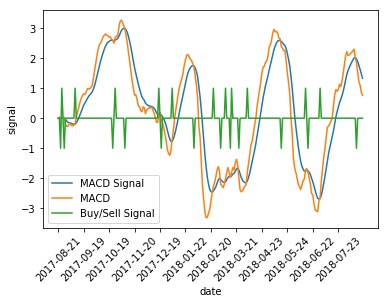

In [10]:
df.reset_index(inplace=True)
sns.lineplot(data=stock, x='date', y='macds', label='MACD Signal')
sns.lineplot(data=stock, x='date', y='macd', label='MACD')

stock['signal'] = stock['signal'].replace('BUY', 1).replace('SELL', -1).replace('HOLD', 0).replace('No data', 0)
sns.lineplot(data=stock, x='date', y='signal', label='Buy/Sell Signal')

l=stock.date.count()/12
plt.xticks(stock.date[0::int(l)], rotation=45)
plt.show()

Some stats ...

In [11]:
BUY_cnt = stock[stock['signal']==1].shape[0]
SELL_cnt = stock[stock['signal']==-1].shape[0]
HOLD_cnt = stock[stock['signal']==0].shape[0]
print("BUY: " + str(BUY_cnt))
print("SELL: " + str(SELL_cnt))
print("HOLD: " + str(HOLD_cnt))

BUY: 11
SELL: 12
HOLD: 229
